# Pneumonia Detection from Chest X-Ray Images


## 1. Import Required Libraries

In [3]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Traditional ML Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

# Feature extraction
from sklearn.decomposition import PCA

# Serialization
import pickle
import joblib

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 2. Dataset Configuration and Exploration

In [4]:
# Dataset paths - Update these according to your directory structure
DATASET_PATH = 'chest_xray'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TEST_PATH = os.path.join(DATASET_PATH, 'test')
VAL_PATH = os.path.join(DATASET_PATH, 'val')

# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 10

# Categories
CATEGORIES = ['NORMAL', 'PNEUMONIA']

In [5]:
# Explore dataset structure
def count_images(directory):
    counts = {}
    for category in CATEGORIES:
        path = os.path.join(directory, category)
        if os.path.exists(path):
            counts[category] = len(os.listdir(path))
    return counts

train_counts = count_images(TRAIN_PATH)
test_counts = count_images(TEST_PATH)
val_counts = count_images(VAL_PATH)

print("Dataset Distribution:")
print(f"Training Set: {train_counts}")
print(f"Validation Set: {val_counts}")
print(f"Test Set: {test_counts}")
print(f"\nTotal Training Images: {sum(train_counts.values())}")
print(f"Total Validation Images: {sum(val_counts.values())}")
print(f"Total Test Images: {sum(test_counts.values())}")

Dataset Distribution:
Training Set: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation Set: {'NORMAL': 8, 'PNEUMONIA': 8}
Test Set: {'NORMAL': 234, 'PNEUMONIA': 390}

Total Training Images: 5216
Total Validation Images: 16
Total Test Images: 624


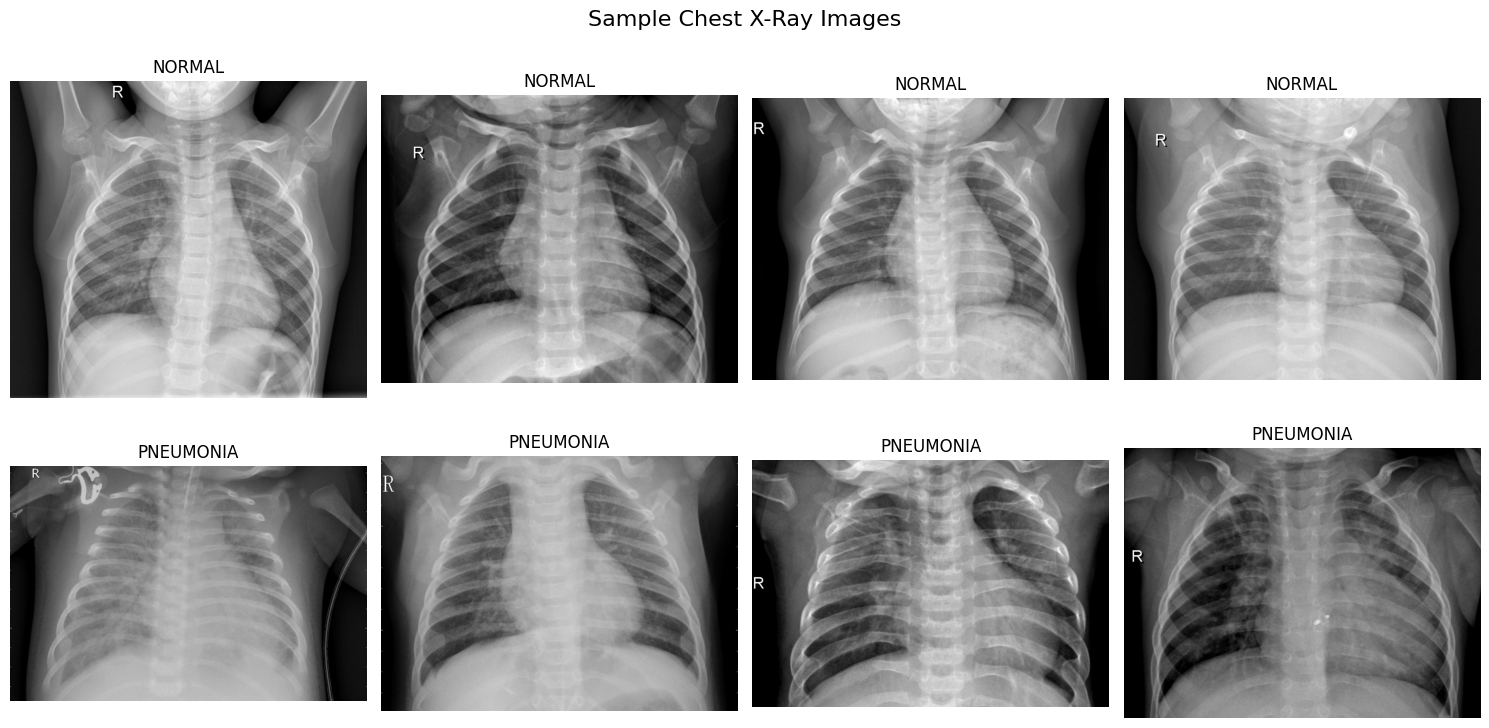

In [6]:
# Visualize sample images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Chest X-Ray Images', fontsize=16)

for i, category in enumerate(CATEGORIES):
    category_path = os.path.join(TRAIN_PATH, category)
    images = os.listdir(category_path)[:4]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{category}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Data Preprocessing and Augmentation

In [7]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Test batches: {len(test_generator)}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training batches: 163
Validation batches: 1
Test batches: 20


## 4. Feature Extraction for Traditional ML Models

In [8]:
def load_and_preprocess_images(directory, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load images and extract features for traditional ML models
    """
    features = []
    labels = []
    
    for category_idx, category in enumerate(CATEGORIES):
        category_path = os.path.join(directory, category)
        print(f"Processing {category}...")
        
        for img_name in os.listdir(category_path):
            try:
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                img = img.flatten() / 255.0  # Normalize
                features.append(img)
                labels.append(category_idx)
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
    
    return np.array(features), np.array(labels)

# Load data for traditional ML models
print("Loading training data...")
X_train_ml, y_train_ml = load_and_preprocess_images(TRAIN_PATH)
print(f"Training data shape: {X_train_ml.shape}")

print("\nLoading test data...")
X_test_ml, y_test_ml = load_and_preprocess_images(TEST_PATH)
print(f"Test data shape: {X_test_ml.shape}")

Loading training data...
Processing NORMAL...
Processing PNEUMONIA...
Training data shape: (5216, 22500)

Loading test data...
Processing NORMAL...
Processing PNEUMONIA...
Test data shape: (624, 22500)


In [9]:
# Apply PCA for dimensionality reduction (optional but recommended for large images)
pca = PCA(n_components=500, random_state=42)
X_train_pca = pca.fit_transform(X_train_ml)
X_test_pca = pca.transform(X_test_ml)

print(f"PCA reduced shape: {X_train_pca.shape}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Save PCA model
joblib.dump(pca, 'pca_model.pkl')

PCA reduced shape: (5216, 500)
Explained variance ratio: 0.9420


['pca_model.pkl']

## 5. Traditional Machine Learning Models

In [10]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Dictionary to store results
ml_results = {}

def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model and store results
    """
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results:")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred, target_names=CATEGORIES)}")
    
    return results

### 5.1 Logistic Regression

In [11]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_pca, y_train_ml)
ml_results['Logistic Regression'] = evaluate_model(lr_model, X_test_pca, y_test_ml, 'Logistic Regression')

# Save model
joblib.dump(lr_model, 'models/logistic_regression.pkl')

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7420
Precision: 0.7116
Recall: 0.9872
F1-Score: 0.8271

Confusion Matrix:
[[ 78 156]
 [  5 385]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.33      0.49       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624



['models/logistic_regression.pkl']

### 5.2 Support Vector Machine (SVM)

In [12]:
print("Training Support Vector Machine...")
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train_pca, y_train_ml)
ml_results['SVM'] = evaluate_model(svm_model, X_test_pca, y_test_ml, 'Support Vector Machine')

# Save model
joblib.dump(svm_model, 'models/svm_model.pkl')

Training Support Vector Machine...

Support Vector Machine Results:
Accuracy: 0.7708
Precision: 0.7361
Recall: 0.9872
F1-Score: 0.8434

Confusion Matrix:
[[ 96 138]
 [  5 385]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.41      0.57       234
   PNEUMONIA       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



['models/svm_model.pkl']

### 5.3 Random Forest

In [13]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_pca, y_train_ml)
ml_results['Random Forest'] = evaluate_model(rf_model, X_test_pca, y_test_ml, 'Random Forest')

# Save model
joblib.dump(rf_model, 'models/random_forest.pkl')

Training Random Forest...

Random Forest Results:
Accuracy: 0.6747
Precision: 0.6587
Recall: 0.9949
F1-Score: 0.7926

Confusion Matrix:
[[ 33 201]
 [  2 388]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.14      0.25       234
   PNEUMONIA       0.66      0.99      0.79       390

    accuracy                           0.67       624
   macro avg       0.80      0.57      0.52       624
weighted avg       0.77      0.67      0.59       624



['models/random_forest.pkl']

### 5.4 Decision Tree

In [14]:
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train_pca, y_train_ml)
ml_results['Decision Tree'] = evaluate_model(dt_model, X_test_pca, y_test_ml, 'Decision Tree')

# Save model
joblib.dump(dt_model, 'models/decision_tree.pkl')

Training Decision Tree...

Decision Tree Results:
Accuracy: 0.7420
Precision: 0.7304
Recall: 0.9308
F1-Score: 0.8185

Confusion Matrix:
[[100 134]
 [ 27 363]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.79      0.43      0.55       234
   PNEUMONIA       0.73      0.93      0.82       390

    accuracy                           0.74       624
   macro avg       0.76      0.68      0.69       624
weighted avg       0.75      0.74      0.72       624



['models/decision_tree.pkl']

### 5.5 Naive Bayes

In [15]:
print("Training Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train_pca, y_train_ml)
ml_results['Naive Bayes'] = evaluate_model(nb_model, X_test_pca, y_test_ml, 'Naive Bayes')

# Save model
joblib.dump(nb_model, 'models/naive_bayes.pkl')

Training Naive Bayes...

Naive Bayes Results:
Accuracy: 0.7131
Precision: 0.7221
Recall: 0.8795
F1-Score: 0.7931

Confusion Matrix:
[[102 132]
 [ 47 343]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.68      0.44      0.53       234
   PNEUMONIA       0.72      0.88      0.79       390

    accuracy                           0.71       624
   macro avg       0.70      0.66      0.66       624
weighted avg       0.71      0.71      0.70       624



['models/naive_bayes.pkl']

## 6. Deep Learning Models

### 6.1 Custom CNN Model

In [16]:
def create_custom_cnn():
    """
    Create a custom CNN architecture
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Flatten and Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile model
cnn_model = create_custom_cnn()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,944,961 (26.49 MB)

 Trainable params: 6,944,001 (26.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    'models/cnn_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train model
print("Training Custom CNN...")
cnn_history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Training Custom CNN...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.7848 - loss: 0.6913 - precision: 0.8560 - recall: 0.8508

163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 897ms/step - accuracy: 0.8148 - loss: 0.5508 - precision: 0.8717 - recall: 0.8803 - val_accuracy: 0.5000 - val_loss: 7.6019 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 843ms/step - accuracy: 0.8597 - loss: 0.3409 - precision: 0.9028 - recall: 0.9089 - val_accuracy: 0.5000 - val_loss: 12.4564 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8783 - loss: 0.2925 - precision: 0.9173 - recall: 0.9190 - val_accuracy: 0.5000 - val_loss: 8.6755 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.8738 - loss: 0.2851 - precision: 0.9162 - recall: 0.9131

163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 827ms/step - accuracy: 0.8855 - loss: 0.2658 - precision: 0.9264 - recall: 0.9190 - val_accuracy: 0.6250 - val_loss: 1.7377 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/10
126/163 ━━━━━━━━━━━━━━━━━━━━ 29s 795ms/step - accuracy: 0.9018 - loss: 0.2385 - precision: 0.9443 - recall: 0.9214

### 6.2 VGG16 Transfer Learning

In [ ]:
def create_vgg16_model():
    """
    Create VGG16 transfer learning model
    """
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile VGG16 model
vgg16_model = create_vgg16_model()
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train VGG16 model
print("Training VGG16 Model...")
vgg16_checkpoint = ModelCheckpoint(
    'models/vgg16_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, vgg16_checkpoint]
)

Training VGG16 Model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6862 - loss: 0.6021 - precision_2: 0.7472 - recall_2: 0.8740

163/163 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.7274 - loss: 0.5604 - precision_2: 0.7487 - recall_2: 0.9528 - val_accuracy: 0.5000 - val_loss: 0.6666 - val_precision_2: 0.5000 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7697 - loss: 0.4729 - precision_2: 0.7754 - recall_2: 0.9709

163/163 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.7860 - loss: 0.4455 - precision_2: 0.7904 - recall_2: 0.9690 - val_accuracy: 0.7500 - val_loss: 0.4510 - val_precision_2: 0.6667 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.8384 - loss: 0.3563 - precision_2: 0.8537 - recall_2: 0.9443 - val_accuracy: 0.7500 - val_loss: 0.3812 - val_precision_2: 0.6667 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.8585 - loss: 0.3143 - precision_2: 0.8845 - recall_2: 0.9311 - val_accuracy: 0.7500 - val_loss: 0.3780 - val_precision_2: 0.6667 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8727 - loss: 0.2913 - precision_2: 0.8976 - recall_2: 0.9339

163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8740 - loss: 0.2853 - precision_2: 0.9010 - recall_2: 0.9329 - val_accuracy: 0.8750 - val_loss: 0.3585 - val_precision_2: 0.8000 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8875 - loss: 0.2602 - precision_2: 0.9152 - recall_2: 0.9352 - val_accuracy: 0.8750 - val_loss: 0.3418 - val_precision_2: 0.8000 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.8909 - loss: 0.2522 - precision_2: 0.9228 - recall_2: 0.9311 - val_accuracy: 0.8750 - val_loss: 0.3250 - val_precision_2: 0.8000 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8969 - loss: 0.2432 - precision_2: 0.9279 - recall_2: 0.9337 - val_accuracy: 0.8750 - val_loss: 0.3573 - val_precision_2: 0.8000 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/10
163/163 ━━━━

### 6.3 ResNet50 Transfer Learning

In [ ]:
def create_resnet50_model():
    """
    Create ResNet50 transfer learning model
    """
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile ResNet50 model
resnet_model = create_resnet50_model()
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

resnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train ResNet50 model
print("Training ResNet50 Model...")
resnet_checkpoint = ModelCheckpoint(
    'models/resnet50_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, resnet_checkpoint]
)

Training ResNet50 Model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7050 - loss: 0.6182 - precision_3: 0.7474 - recall_3: 0.9119

163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 748ms/step - accuracy: 0.7239 - loss: 0.6012 - precision_3: 0.7424 - recall_3: 0.9623 - val_accuracy: 0.5000 - val_loss: 0.8105 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 717ms/step - accuracy: 0.7416 - loss: 0.5733 - precision_3: 0.7437 - recall_3: 0.9951 - val_accuracy: 0.5000 - val_loss: 0.8253 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 719ms/step - accuracy: 0.7408 - loss: 0.5598 - precision_3: 0.7435 - recall_3: 0.9941 - val_accuracy: 0.5000 - val_loss: 0.8117 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.7425 - loss: 0.5456 - precision_3: 0.7438 - recall_3: 0.9966 - val_accuracy: 0.5000 - val_loss: 0.7927 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 2.0000e-05
Epoch 5/10


## 7. Model Evaluation and Comparison

In [ ]:
# Evaluate deep learning models on test set
dl_results = {}

# CNN Model
cnn_test_loss, cnn_test_acc, cnn_test_prec, cnn_test_rec = cnn_model.evaluate(test_generator)
dl_results['Custom CNN'] = {
    'accuracy': cnn_test_acc,
    'precision': cnn_test_prec,
    'recall': cnn_test_rec,
    'f1_score': 2 * (cnn_test_prec * cnn_test_rec) / (cnn_test_prec + cnn_test_rec)
}

# VGG16 Model
vgg16_test_loss, vgg16_test_acc, vgg16_test_prec, vgg16_test_rec = vgg16_model.evaluate(test_generator)
dl_results['VGG16'] = {
    'accuracy': vgg16_test_acc,
    'precision': vgg16_test_prec,
    'recall': vgg16_test_rec,
    'f1_score': 2 * (vgg16_test_prec * vgg16_test_rec) / (vgg16_test_prec + vgg16_test_rec)
}

# ResNet50 Model
resnet_test_loss, resnet_test_acc, resnet_test_prec, resnet_test_rec = resnet_model.evaluate(test_generator)
dl_results['ResNet50'] = {
    'accuracy': resnet_test_acc,
    'precision': resnet_test_prec,
    'recall': resnet_test_rec,
    'f1_score': 2 * (resnet_test_prec * resnet_test_rec) / (resnet_test_prec + resnet_test_rec)
}

print("\nDeep Learning Models Test Results:")
for model_name, metrics in dl_results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.8654 - loss: 0.3095 - precision_1: 0.9091 - recall_1: 0.8718
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8686 - loss: 0.3160 - precision_2: 0.8909 - recall_2: 0.9000
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 618ms/step - accuracy: 0.6250 - loss: 0.6797 - precision_3: 0.6250 - recall_3: 1.0000

Deep Learning Models Test Results:

Custom CNN:
  Accuracy: 0.8654
  Precision: 0.9091
  Recall: 0.8718
  F1-Score: 0.8901

VGG16:
  Accuracy: 0.8686
  Precision: 0.8909
  Recall: 0.9000
  F1-Score: 0.8954

ResNet50:
  Accuracy: 0.6250
  Precision: 0.6250
  Recall: 1.0000
  F1-Score: 0.7692


In [ ]:
# Combine all results
all_results = {}

# Add ML results
for model_name, metrics in ml_results.items():
    all_results[model_name] = {
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score']
    }

# Add DL results
all_results.update(dl_results)

# Create comparison DataFrame
results_df = pd.DataFrame(all_results).T
results_df = results_df.round(4)
results_df = results_df.sort_values('accuracy', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df)

# Save results
results_df.to_csv('model_comparison_results.csv')


MODEL COMPARISON SUMMARY
                     accuracy  precision  recall  f1_score
VGG16                  0.8686     0.8909  0.9000    0.8954
Custom CNN             0.8654     0.9091  0.8718    0.8901
SVM                    0.7708     0.7361  0.9872    0.8434
Logistic Regression    0.7420     0.7116  0.9872    0.8271
Decision Tree          0.7420     0.7304  0.9308    0.8185
Naive Bayes            0.7131     0.7221  0.8795    0.7931
Random Forest          0.6747     0.6587  0.9949    0.7926
ResNet50               0.6250     0.6250  1.0000    0.7692


## 8. Visualization

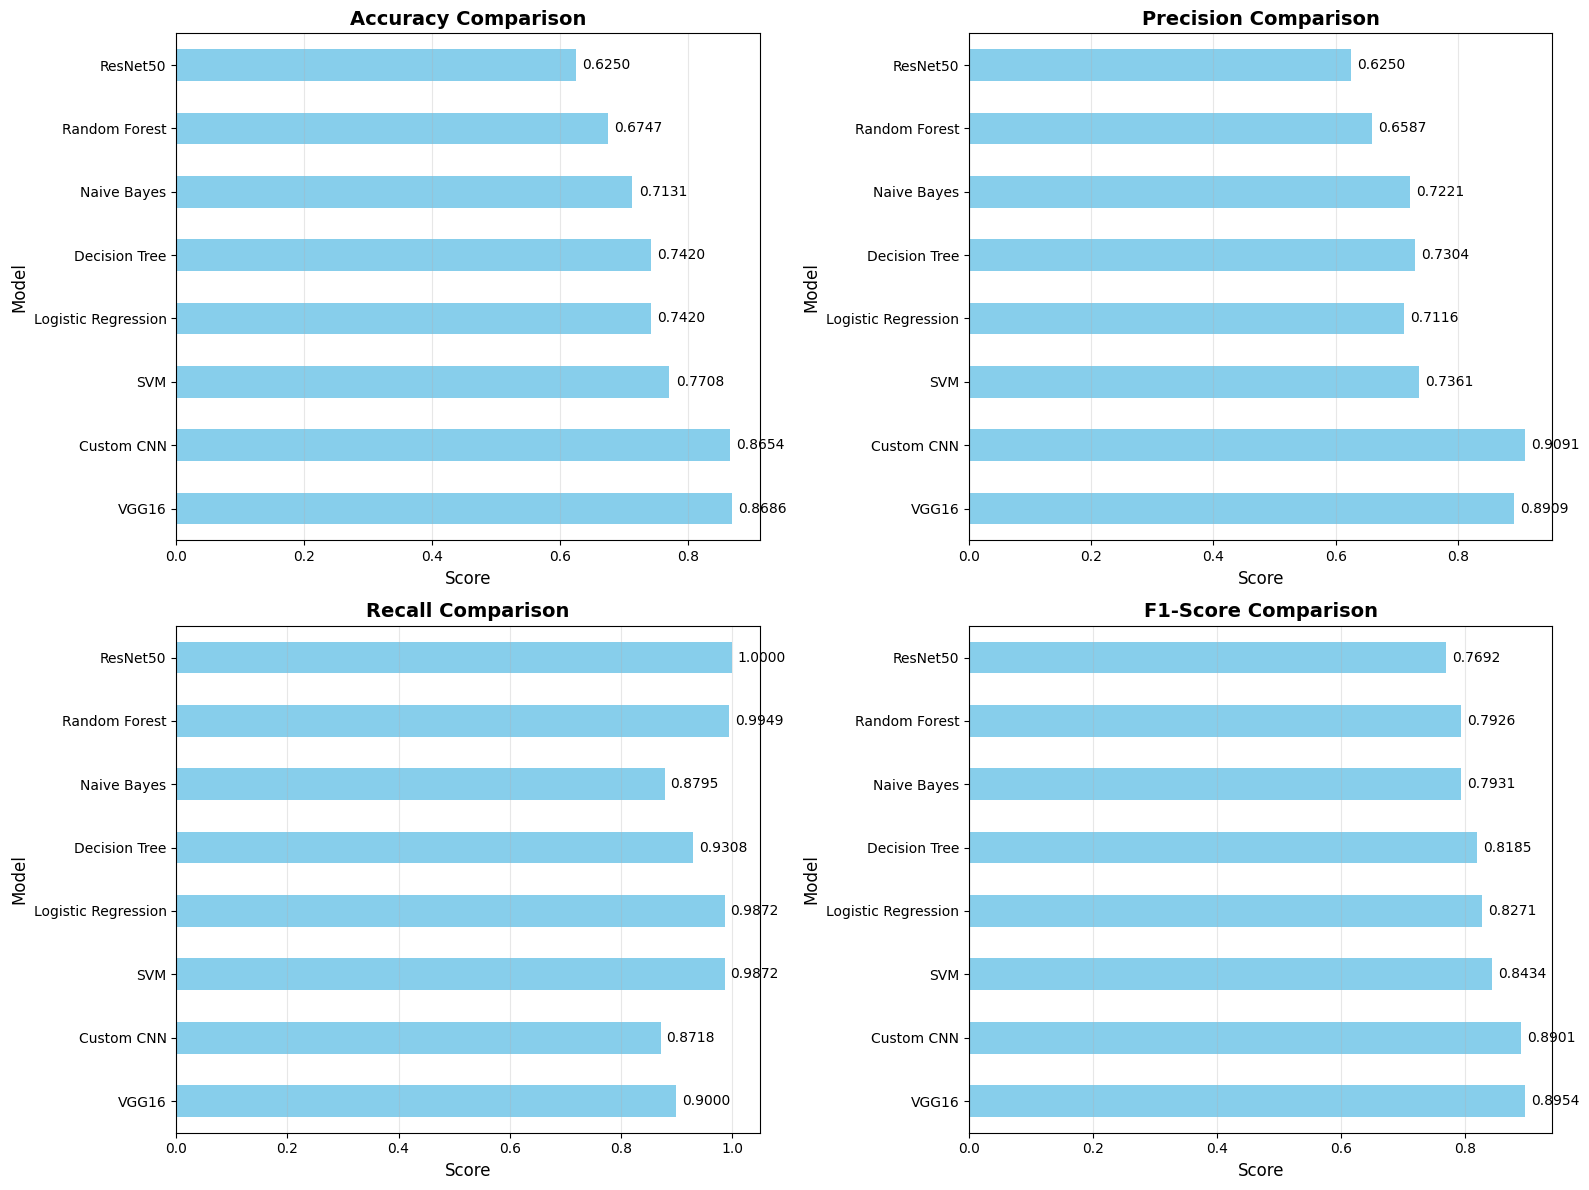

In [ ]:
# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy Comparison', 'Precision Comparison', 'Recall Comparison', 'F1-Score Comparison']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    results_df[metric].plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Plot training history for deep learning models
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot histories
plot_training_history(cnn_history, 'Custom CNN')
plot_training_history(vgg16_history, 'VGG16')
plot_training_history(resnet_history, 'ResNet50')
plt.savefig('model_al.png', dpi=150, bbox_inches='tight')

NameError: name 'cnn_history' is not defined

In [ ]:
plt.savefig('.png', dpi=150, bbox_inches='tight')

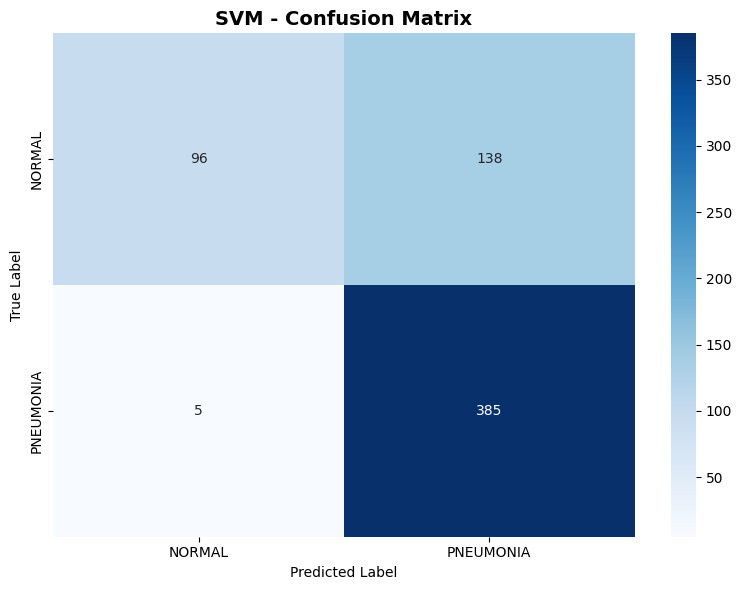

In [ ]:
# Plot confusion matrices for best models
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot confusion matrices for top 3 ML models
top_3_ml = results_df.head(3).index.tolist()
for model_name in top_3_ml:
    if model_name in ml_results:
        plot_confusion_matrix(ml_results[model_name]['confusion_matrix'], model_name)

## 9. Save All Models

In [ ]:
# Save deep learning models
cnn_model.save('models/cnn_model.h5')
vgg16_model.save('models/vgg16_model.h5')
resnet_model.save('models/resnet50_model.h5')

print("All models saved successfully!")
print("\nSaved models:")
print("- Traditional ML: Logistic Regression, SVM, Random Forest, Decision Tree, Naive Bayes")
print("- Deep Learning: Custom CNN, VGG16, ResNet50")
print("- PCA model for dimensionality reduction")

All models saved successfully!

Saved models:
- Traditional ML: Logistic Regression, SVM, Random Forest, Decision Tree, Naive Bayes
- Deep Learning: Custom CNN, VGG16, ResNet50
- PCA model for dimensionality reduction


## 10. Best Model Selection and Inference

In [ ]:
# Identify best model
best_model_name = results_df['accuracy'].idxmax()
best_accuracy = results_df['accuracy'].max()

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"{'='*80}")

# Save best model info
best_model_info = {
    'model_name': best_model_name,
    'accuracy': best_accuracy,
    'metrics': results_df.loc[best_model_name].to_dict()
}

with open('models/best_model_info.pkl', 'wb') as f:
    pickle.dump(best_model_info, f)


BEST MODEL: VGG16
Test Accuracy: 0.8686



Sample Prediction:
Prediction: PNEUMONIA
Confidence: 0.6072


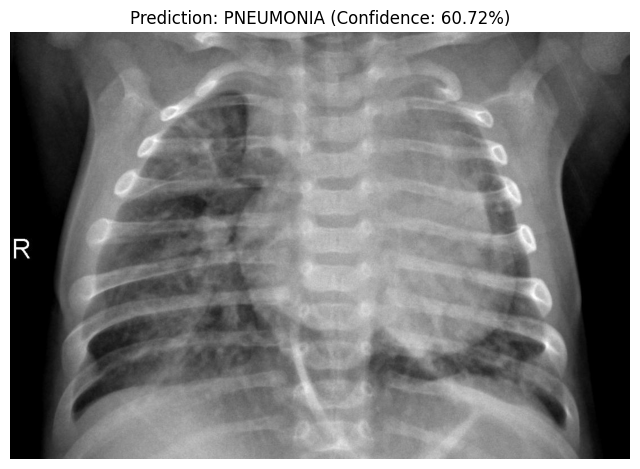

In [ ]:
# Test prediction function
def predict_pneumonia(image_path, model, model_type='dl'):
    """
    Predict pneumonia from a chest X-ray image
    """
    if model_type == 'dl':
        # For deep learning models
        img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array, verbose=0)[0][0]
    else:
        # For traditional ML models
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = img.flatten() / 255.0
        img = img.reshape(1, -1)
        img = pca.transform(img)
        prediction = model.predict_proba(img)[0][1]
    
    result = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return result, confidence

# Test on a sample image
test_image_path = os.path.join(TEST_PATH, 'PNEUMONIA', os.listdir(os.path.join(TEST_PATH, 'PNEUMONIA'))[0])
result, confidence = predict_pneumonia(test_image_path, cnn_model, 'dl')

print(f"\nSample Prediction:")
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.4f}")

# Display the image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f'Prediction: {result} (Confidence: {confidence:.2%})')
plt.axis('off')
plt.show()

## 11. Summary and Conclusions

In [ ]:
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print(f"\nDataset: Chest X-Ray Pneumonia Detection")
print(f"Total Training Images: {sum(train_counts.values())}")
print(f"Total Test Images: {sum(test_counts.values())}")
print(f"\nModels Implemented: {len(all_results)}")
print(f"  - Traditional ML Models: 5")
print(f"  - Deep Learning Models: 3")
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print("\nTop 3 Models:")
for i, (model, acc) in enumerate(results_df['accuracy'].head(3).items(), 1):
    print(f"  {i}. {model}: {acc:.4f}")
print("\n" + "="*80)


PROJECT SUMMARY

Dataset: Chest X-Ray Pneumonia Detection
Total Training Images: 5216
Total Test Images: 624

Models Implemented: 8
  - Traditional ML Models: 5
  - Deep Learning Models: 3

Best Model: VGG16
Best Accuracy: 0.8686

Top 3 Models:
  1. VGG16: 0.8686
  2. Custom CNN: 0.8654
  3. SVM: 0.7708



#Test On New Dataset


In [ ]:
# Model path - this is the best model saved from training
MODEL_PATH = 'models/vgg16_best_model.h5'
NEW_TEST_DIR = 'data/chest_xray/test'
os.makedirs('test_results', exist_ok=True)

print("Configuration set successfully!")
print(f"Model path: {MODEL_PATH}")
print(f"Test dataset: {NEW_TEST_DIR}")

Configuration set successfully!
Model path: models/vgg16_best_model.h5
Test dataset: data/chest_xray/test


In [ ]:
# Check if model exists
if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
    print("Please train the model first using pneumonia_detection.ipynb")
else:
    # Load the model
    print("Loading trained model...")
    model = keras.models.load_model(MODEL_PATH)
    print("✓ Model loaded successfully!")
    
    # Display model summary
    print("\nModel Architecture:")
    model.summary()
    
    # Display model metrics
    print(f"\nModel Input Shape: {model.input_shape}")
    print(f"Model Output Shape: {model.output_shape}")
    print(f"Total Parameters: {model.count_params():,}")

Loading trained model...


✓ Model loaded successfully!

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,043 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)


Model Input Shape: (None, 150, 150, 3)
Model Output Shape: (None, 1)
Total Parameters: 14,879,041


In [ ]:
# Check if test directory exists
if not os.path.exists(NEW_TEST_DIR):
    print(f"ERROR: Test directory not found at {NEW_TEST_DIR}")
    print("Please update NEW_TEST_DIR in Step 2")
else:
    # Create data generator (only rescaling, no augmentation for testing)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Load test data
    test_generator = test_datagen.flow_from_directory(
        NEW_TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # Important: don't shuffle for evaluation
    )
    
    print(f"\n✓ Test dataset loaded successfully!")
    print(f"Total test samples: {test_generator.samples}")
    print(f"Number of classes: {len(test_generator.class_indices)}")
    print(f"Class indices: {test_generator.class_indices}")
    
    # Count images per class
    class_counts = pd.Series(test_generator.classes).value_counts().sort_index()
    print(f"\nClass distribution:")
    for idx, count in class_counts.items():
        class_name = list(test_generator.class_indices.keys())[idx]
        print(f"  {class_name}: {count} images ({count/test_generator.samples*100:.1f}%)")

ERROR: Test directory not found at data/chest_xray/test
Please update NEW_TEST_DIR in Step 2


In [ ]:
print("Making predictions on test dataset...")
print("This may take a few minutes...\n")

# Get predictions
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

print("\n✓ Predictions completed!")
print(f"Total predictions: {len(y_pred)}")

Making predictions on test dataset...
This may take a few minutes...

20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

✓ Predictions completed!
Total predictions: 624


In [ ]:
# Calculate all metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)  # True Negative Rate


# Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate confusion matrix components
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
negative_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE METRICS")
print("="*80)

print("\n📊 Basic Metrics:")
print(f"  Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision:          {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall/Sensitivity: {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:           {f1:.4f}")
print(f"  Specificity:        {specificity:.4f} ({specificity*100:.2f}%)")

print("\n📈 Advanced Metrics:")
print(f"  ROC AUC Score:      {roc_auc:.4f}")
print(f"  NPV:                {negative_predictive_value:.4f}")

print("\n⚠️ Error Rates:")
print(f"  False Positive Rate: {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
print(f"  False Negative Rate: {false_negative_rate:.4f} ({false_negative_rate*100:.2f}%)")

print("\n🔢 Confusion Matrix Components:")
print(f"  True Positives:  {tp}")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")

print("\n" + "="*80)


COMPREHENSIVE PERFORMANCE METRICS

📊 Basic Metrics:
  Accuracy:           0.8542 (85.42%)
  Precision:          0.8673 (86.73%)
  Recall/Sensitivity: 0.9051 (90.51%)
  F1-Score:           0.8858
  Specificity:        0.7692 (76.92%)

📈 Advanced Metrics:
  ROC AUC Score:      0.9296
  NPV:                0.8295

⚠️ Error Rates:
  False Positive Rate: 0.2308 (23.08%)
  False Negative Rate: 0.0949 (9.49%)

🔢 Confusion Matrix Components:
  True Positives:  353
  True Negatives:  180
  False Positives: 54
  False Negatives: 37



In [ ]:
# Create comprehensive metrics dataframe
metrics_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision',
        'Recall (Sensitivity)',
        'Specificity',
        'F1-Score',
        'ROC AUC',
        'NPV',
        'False Positive Rate',
        'False Negative Rate'
    ],
    'Value': [
        accuracy,
        precision,
        recall,
        specificity,
        f1,
        roc_auc,
        negative_predictive_value,
        false_positive_rate,
        false_negative_rate
    ],
    'Percentage': [
        f"{accuracy*100:.2f}%",
        f"{precision*100:.2f}%",
        f"{recall*100:.2f}%",
        f"{specificity*100:.2f}%",
        f"{f1*100:.2f}%",
        f"{roc_auc*100:.2f}%",
        f"{negative_predictive_value*100:.2f}%",
        f"{false_positive_rate*100:.2f}%",
        f"{false_negative_rate*100:.2f}%"
    ]
})

print("\nDetailed Metrics Table:")
print(metrics_df.to_string(index=False))

# Save to CSV
metrics_df.to_csv('test_results/performance_metrics.csv', index=False)
print("\n✓ Metrics saved to 'test_results/performance_metrics.csv'")


Detailed Metrics Table:
              Metric    Value Percentage
            Accuracy 0.854167     85.42%
           Precision 0.867322     86.73%
Recall (Sensitivity) 0.905128     90.51%
         Specificity 0.769231     76.92%
            F1-Score 0.885822     88.58%
             ROC AUC 0.929641     92.96%
                 NPV 0.829493     82.95%
 False Positive Rate 0.230769     23.08%
 False Negative Rate 0.094872      9.49%

✓ Metrics saved to 'test_results/performance_metrics.csv'


In [ ]:
# Get class names
class_names = list(test_generator.class_indices.keys())

# Generate classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Save classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('test_results/classification_report.csv')
print("✓ Classification report saved to 'test_results/classification_report.csv'")


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL     0.8295    0.7692    0.7982       234
   PNEUMONIA     0.8673    0.9051    0.8858       390

    accuracy                         0.8542       624
   macro avg     0.8484    0.8372    0.8420       624
weighted avg     0.8531    0.8542    0.8530       624

✓ Classification report saved to 'test_results/classification_report.csv'


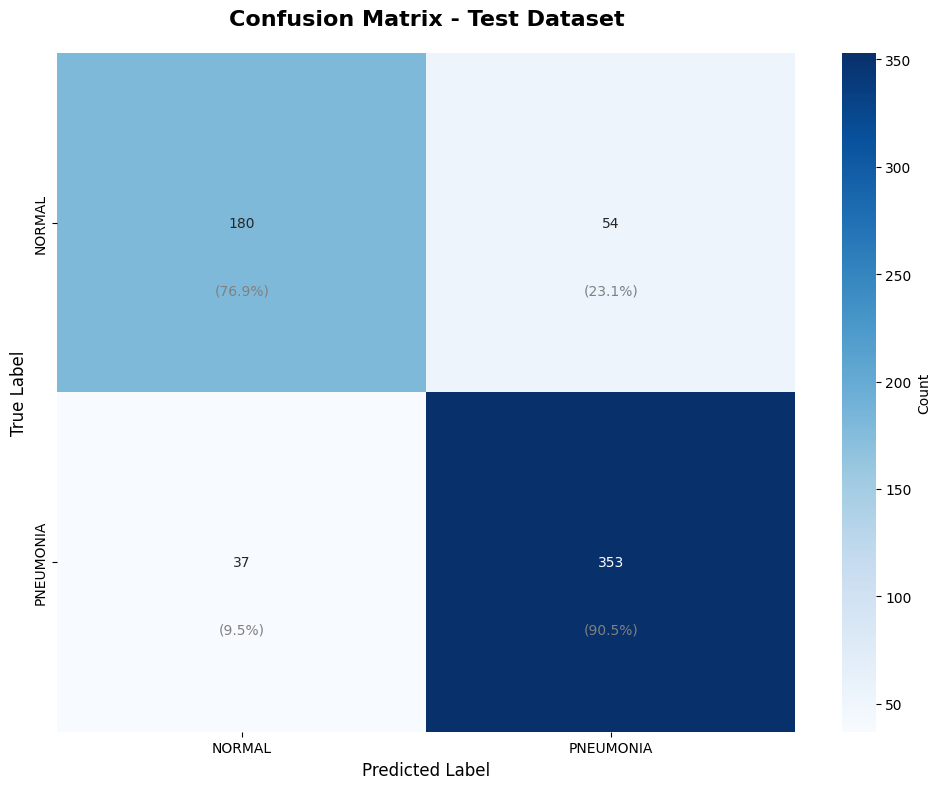

✓ Confusion matrix saved to 'test_results/confusion_matrix.png'


In [ ]:
# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Dataset', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentage annotations
for i in range(len(cm)):
    for j in range(len(cm)):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('test_results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to 'test_results/confusion_matrix.png'")

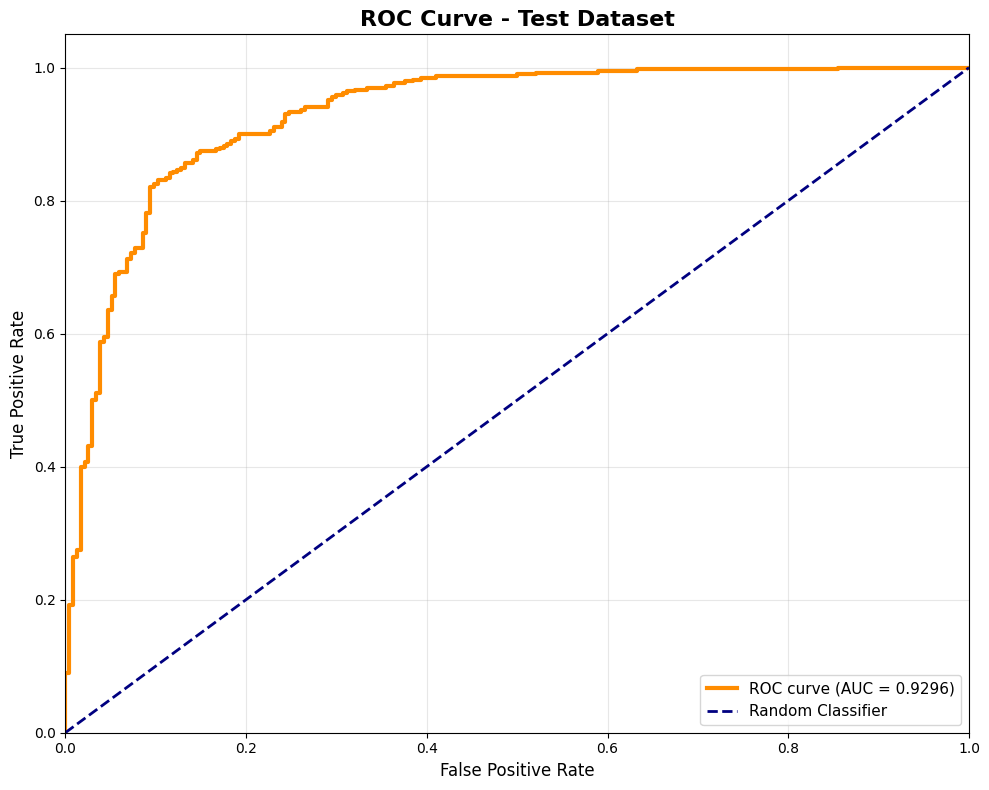

✓ ROC curve saved to 'test_results/roc_curve.png'


In [ ]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Dataset', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('test_results/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved to 'test_results/roc_curve.png'")

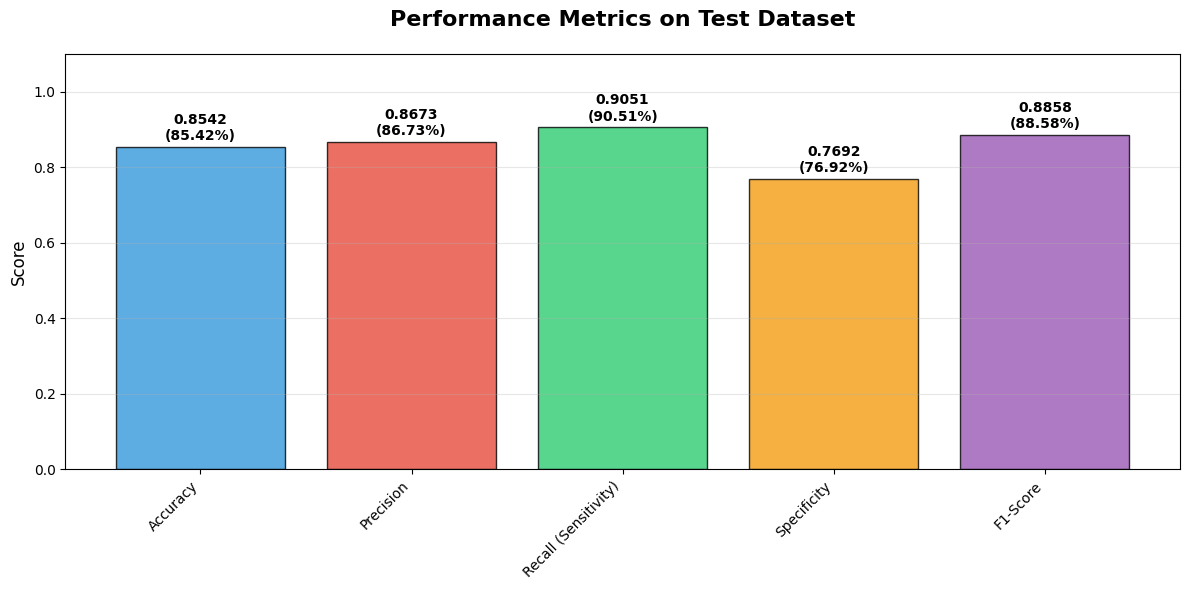

✓ Metrics comparison saved to 'test_results/metrics_comparison.png'


In [ ]:
# Create metrics bar chart
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1-Score']
values_to_plot = [accuracy, precision, recall, specificity, f1]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

bars = ax.bar(metrics_to_plot, values_to_plot, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}\n({height*100:.2f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics on Test Dataset', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('test_results/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison saved to 'test_results/metrics_comparison.png'")

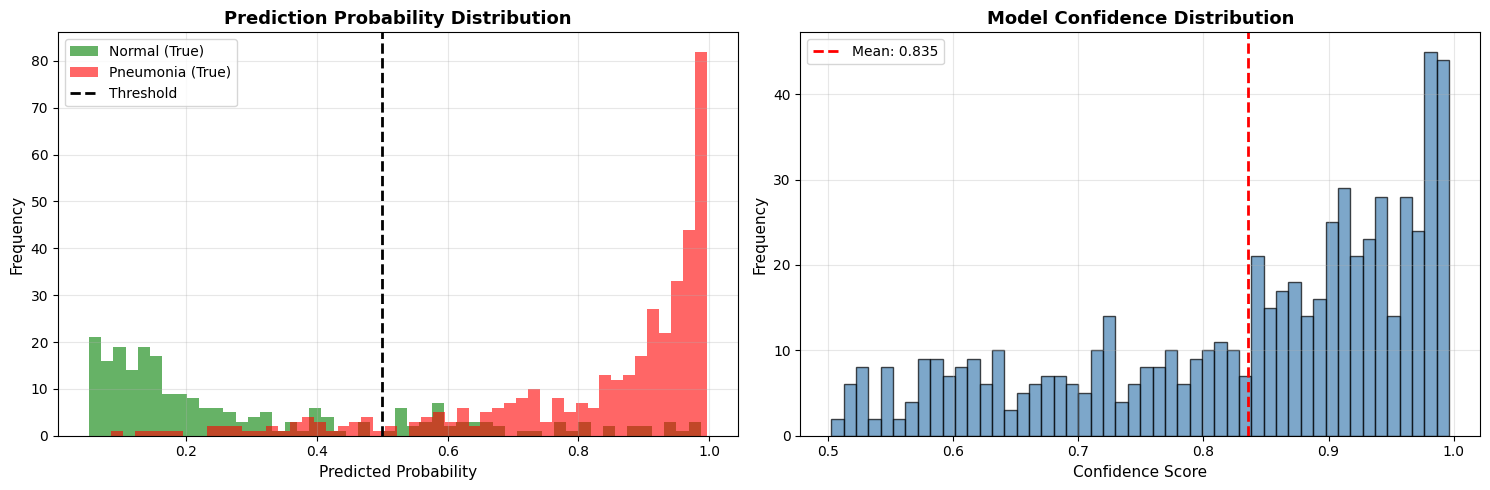

✓ Prediction distribution saved to 'test_results/prediction_distribution.png'

Average confidence score: 0.8354
Min confidence score: 0.5027
Max confidence score: 0.9963


In [ ]:
# Analyze prediction confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Prediction probability distribution
axes[0].hist(y_pred_prob[y_true == 0], bins=50, alpha=0.6, label='Normal (True)', color='green')
axes[0].hist(y_pred_prob[y_true == 1], bins=50, alpha=0.6, label='Pneumonia (True)', color='red')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0].set_xlabel('Predicted Probability', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Prediction Probability Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Confidence distribution
confidence_scores = np.where(y_pred_prob > 0.5, y_pred_prob, 1 - y_pred_prob).flatten()
axes[1].hist(confidence_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=confidence_scores.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {confidence_scores.mean():.3f}')
axes[1].set_xlabel('Confidence Score', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Model Confidence Distribution', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_results/prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction distribution saved to 'test_results/prediction_distribution.png'")
print(f"\nAverage confidence score: {confidence_scores.mean():.4f}")
print(f"Min confidence score: {confidence_scores.min():.4f}")
print(f"Max confidence score: {confidence_scores.max():.4f}")